In [2]:
import pandas as pd
import numpy as np
from typing import Dict, List
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt


# Plots

In [3]:
merged_path = "../data/results/100q_results_filtered.csv"
merged_df = pd.read_csv(merged_path)

In [4]:
# calculate pearson's correlation between simple_metric and adv_metric
correlation = merged_df["simple_metric"].corr(merged_df["adv_metric"])
print(f"Pearson's correlation between simple_metric and adv_metric: {correlation:.4f}")

Pearson's correlation between simple_metric and adv_metric: 0.3324


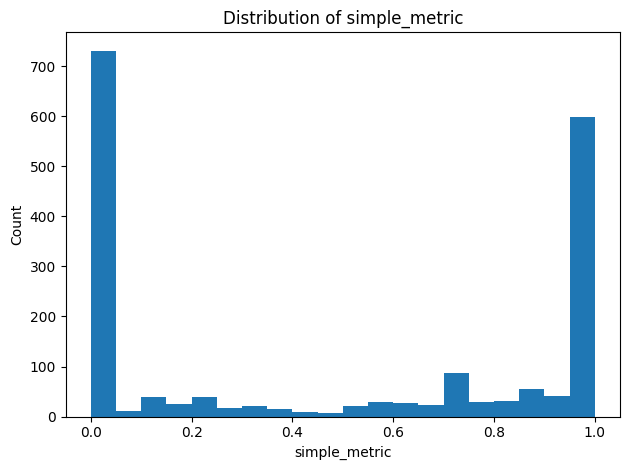

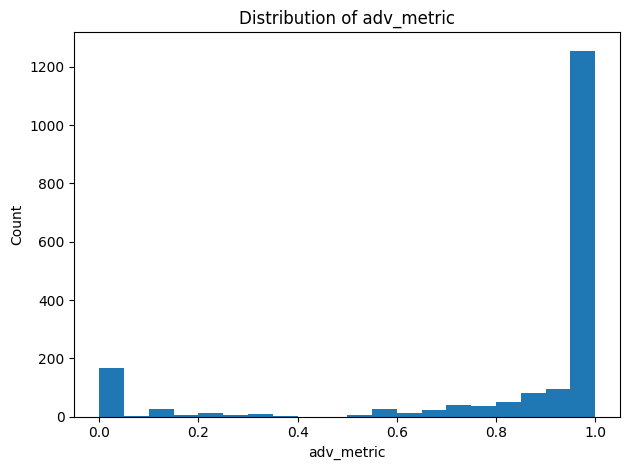

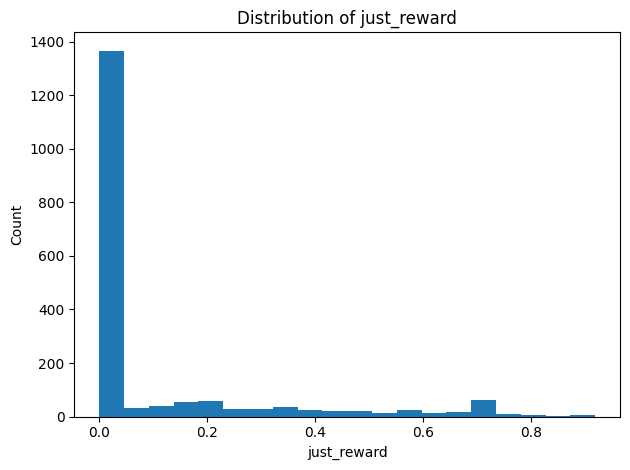

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["simple_conf=False", "simple_conf=True"])


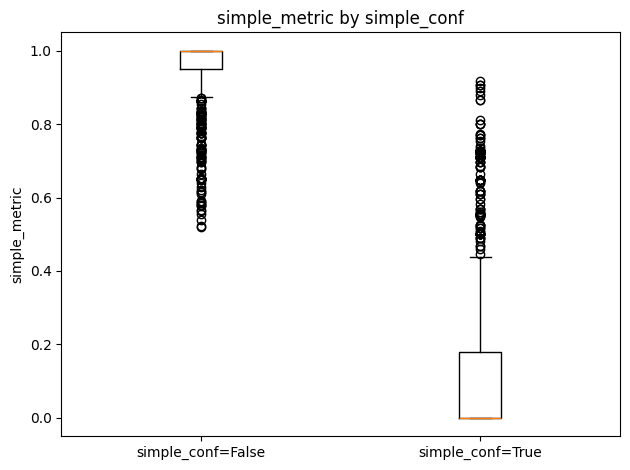

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["simple_conf=False", "simple_conf=True"])


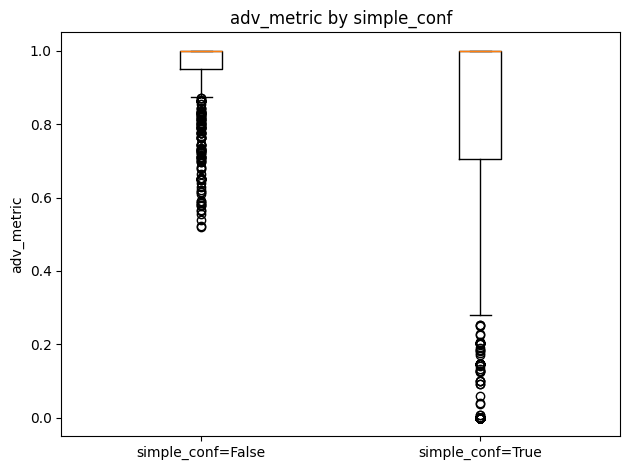

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["simple_conf=False", "simple_conf=True"])


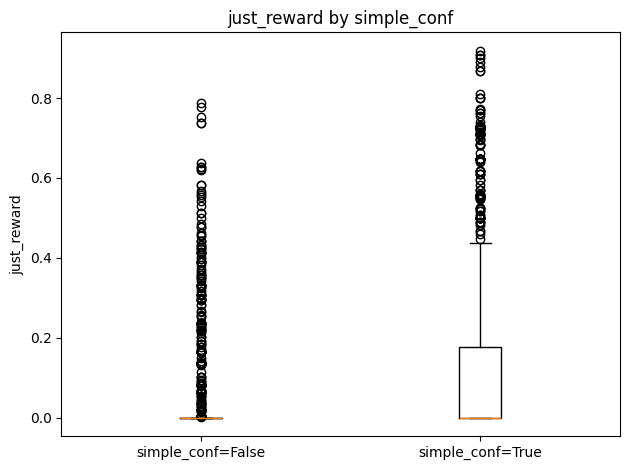

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["adv_conf=False", "adv_conf=True"])


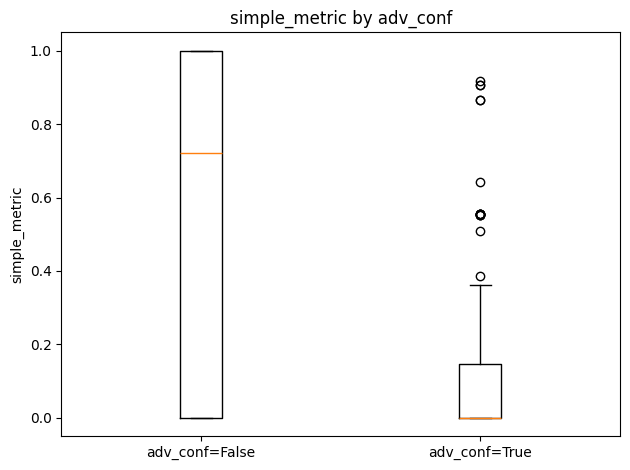

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["adv_conf=False", "adv_conf=True"])


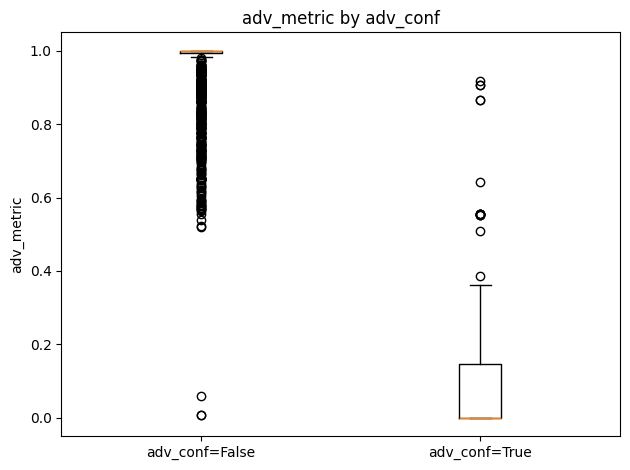

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["adv_conf=False", "adv_conf=True"])


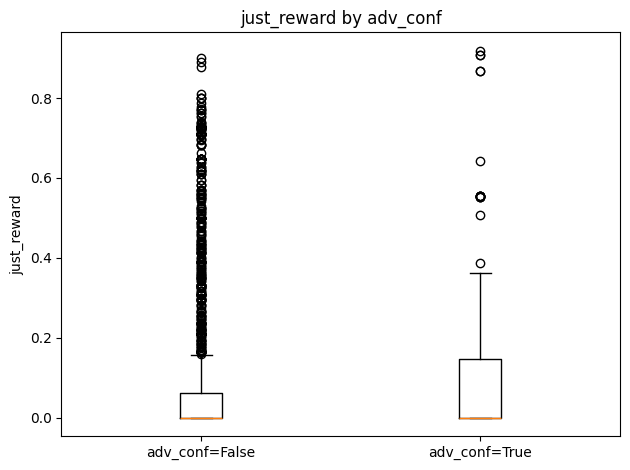

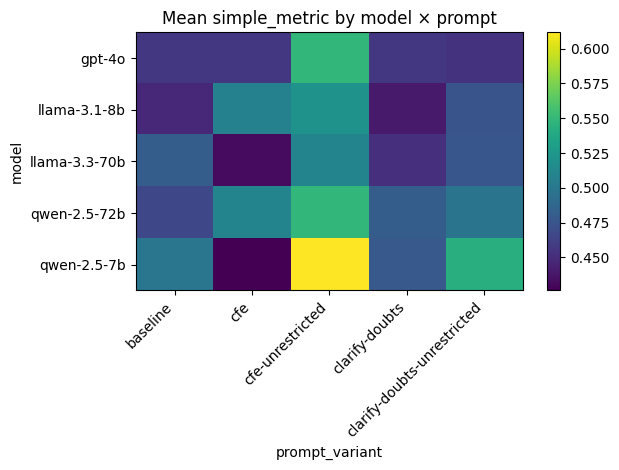

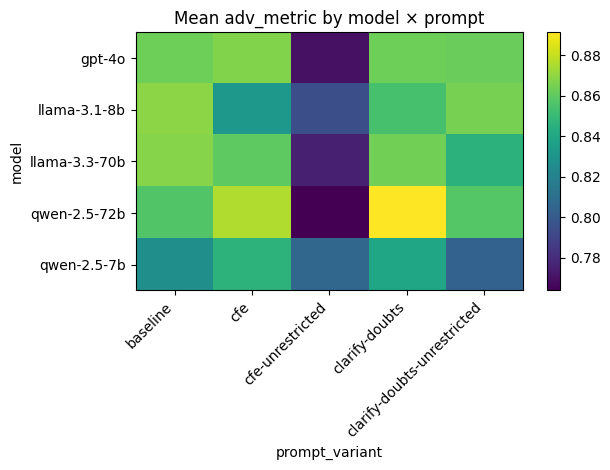

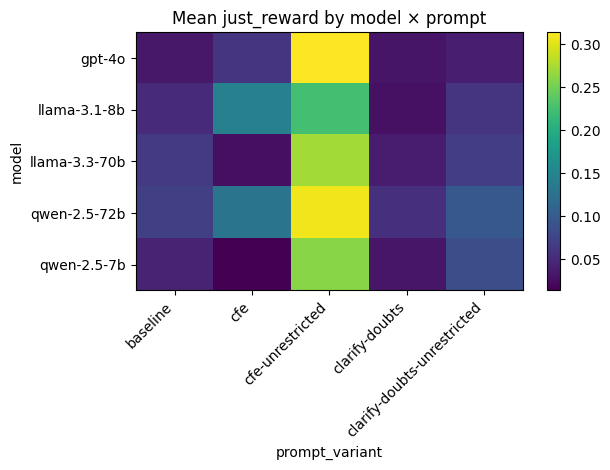

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


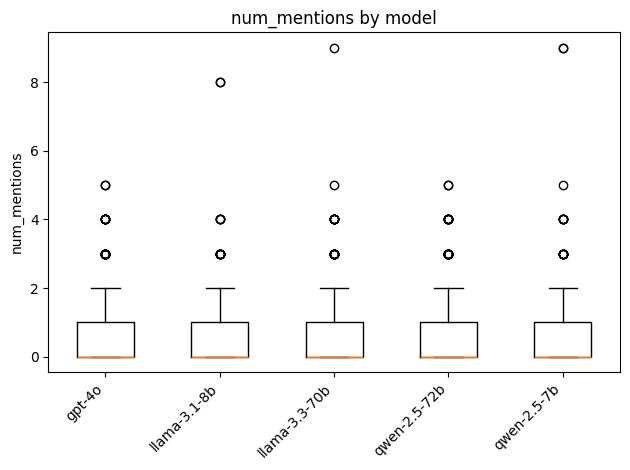

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_15948\451849968.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


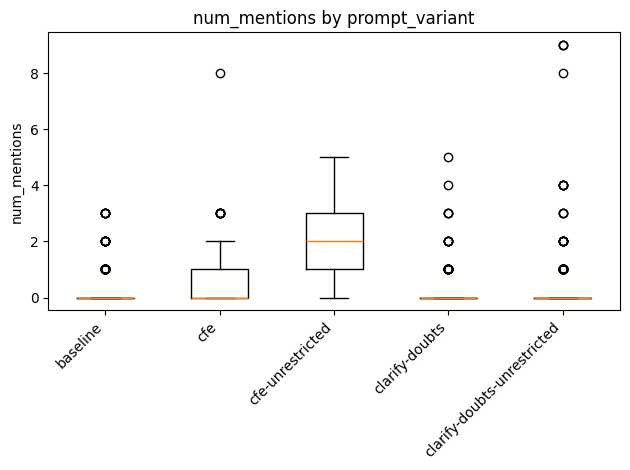

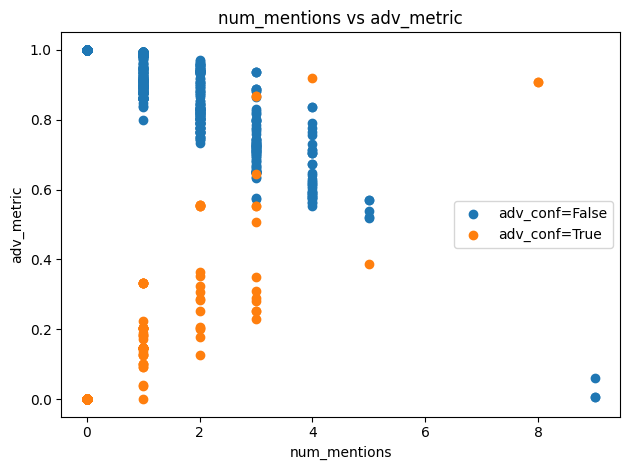

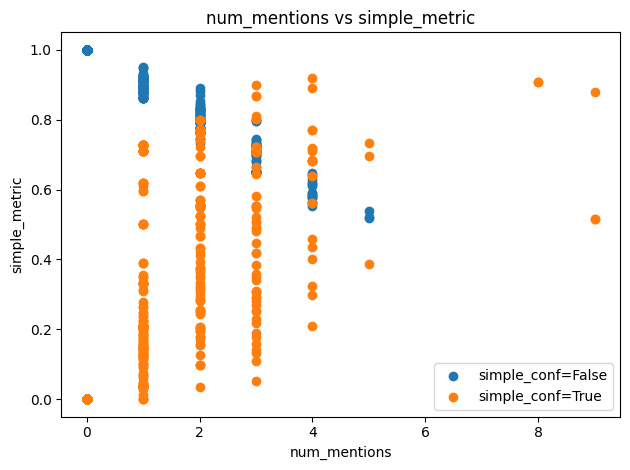

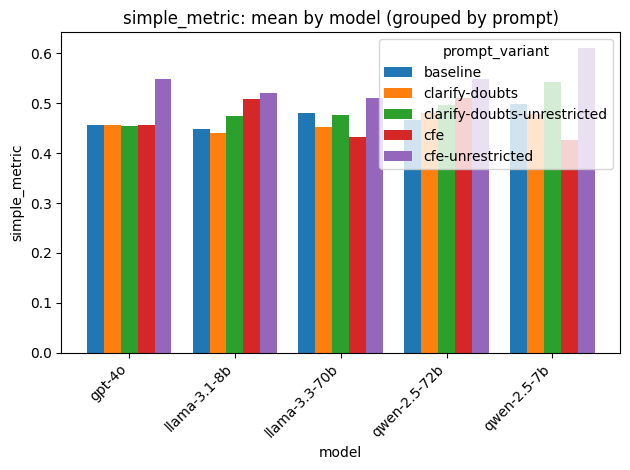

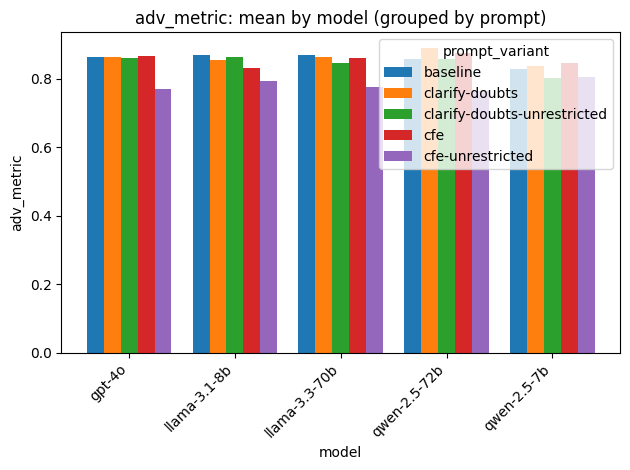

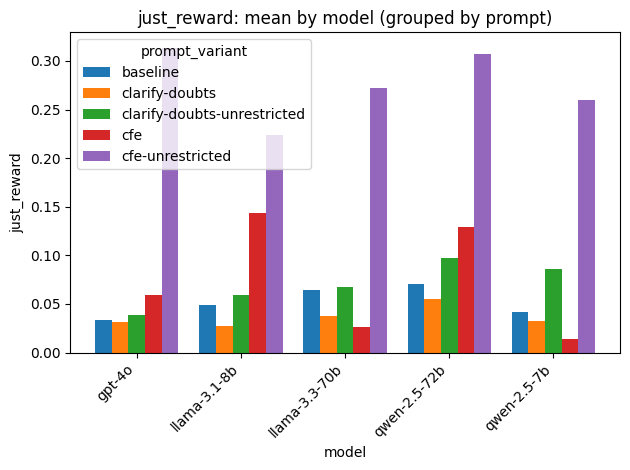

In [5]:
# ------------------------
# 1) Metric distributions (overall)
#     - One histogram per metric
#     - Then boxplots split by labels where available
# ------------------------
metric_cols = [c for c in ["simple_metric", "adv_metric", "just_reward"] if c in merged_df.columns]

# Guardrails: drop rows with all-missing metrics for plotting
if metric_cols:
    merged_df_metrics = merged_df.dropna(subset=metric_cols, how="all").copy()
else:
    merged_df_metrics = merged_df.copy()
for m in metric_cols:
    plt.figure()
    vals = pd.to_numeric(merged_df_metrics[m], errors="coerce").dropna()
    plt.hist(vals, bins=20)
    plt.title(f"Distribution of {m}")
    plt.xlabel(m)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# By label: simple_conf
if "simple_conf" in merged_df_metrics.columns:
    for m in metric_cols:
        plt.figure()
        data0 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["simple_conf"]==False, m], errors="coerce").dropna()
        data1 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["simple_conf"]==True, m], errors="coerce").dropna()
        plt.boxplot([data0, data1], labels=["simple_conf=False", "simple_conf=True"])
        plt.title(f"{m} by simple_conf")
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()

# By label: adv_conf
if "adv_conf" in merged_df_metrics.columns:
    for m in metric_cols:
        plt.figure()
        data0 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["adv_conf"]==False, m], errors="coerce").dropna()
        data1 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["adv_conf"]==True, m], errors="coerce").dropna()
        plt.boxplot([data0, data1], labels=["adv_conf=False", "adv_conf=True"])
        plt.title(f"{m} by adv_conf")
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()

# ------------------------
# 3) Mean metric heatmaps across (model x prompt_variant)
#     - One heatmap per metric (rows=models, cols=prompts)
# ------------------------
if "model" in merged_df_metrics.columns and "prompt_variant" in merged_df_metrics.columns:
    models = sorted(merged_df_metrics["model"].dropna().unique().tolist())
    prompts = sorted(merged_df_metrics["prompt_variant"].dropna().unique().tolist())
    for m in metric_cols:
        piv = merged_df_metrics.pivot_table(index="model", columns="prompt_variant", values=m, aggfunc="mean")
        piv = piv.reindex(index=models, columns=prompts)
        arr = piv.values.astype(float)
        plt.figure()
        plt.imshow(arr, aspect="auto")
        plt.title(f"Mean {m} by model × prompt")
        plt.xlabel("prompt_variant")
        plt.ylabel("model")
        plt.xticks(ticks=np.arange(len(prompts)), labels=prompts, rotation=45, ha="right")
        plt.yticks(ticks=np.arange(len(models)), labels=models)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

# ------------------------
# 4) Agreement between simple vs advanced labels (2x2 confusion)
#     - Heatmap of counts
# ------------------------
""" if "simple_conf" in merged_df_metrics.columns and "adv_conf" in merged_df_metrics.columns:
    ct = pd.crosstab(merged_df_metrics["simple_conf"], merged_df_metrics["adv_conf"])
    arr = ct.values.astype(float)
    plt.figure()
    plt.imshow(arr, aspect="auto")
    plt.title("Agreement: simple_conf (rows) vs adv_conf (cols)")
    plt.xlabel("adv_conf")
    plt.ylabel("simple_conf")
    plt.xticks(ticks=[0,1], labels=["False","True"] if 2 in arr.shape else range(arr.shape[1]))
    plt.yticks(ticks=[0,1], labels=["False","True"] if 2 in arr.shape else range(arr.shape[0]))
    plt.colorbar()
    plt.tight_layout()
    plt.show()
 """

# ------------------------
# 6) Mentions per response by model and by prompt_variant
#     - Boxplot for num_mentions grouped by model (single chart)
#     - Boxplot for num_mentions grouped by prompt (single chart)
# ------------------------
if "model" in merged_df_metrics.columns:
    groups = []
    labels = []
    for g, gmerged_df in merged_df_metrics.groupby("model"):
        vals = pd.to_numeric(gmerged_df["num_mentions"], errors="coerce").dropna()
        if len(vals) > 0:
            groups.append(vals.values)
            labels.append(g)
    if groups:
        plt.figure()
        plt.boxplot(groups, labels=labels)
        plt.title("num_mentions by model")
        plt.ylabel("num_mentions")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

if "prompt_variant" in merged_df_metrics.columns:
    groups = []
    labels = []
    for g, gmerged_df in merged_df_metrics.groupby("prompt_variant"):
        vals = pd.to_numeric(gmerged_df["num_mentions"], errors="coerce").dropna()
        if len(vals) > 0:
            groups.append(vals.values)
            labels.append(g)
    if groups:
        plt.figure()
        plt.boxplot(groups, labels=labels)
        plt.title("num_mentions by prompt_variant")
        plt.ylabel("num_mentions")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# ------------------------
# 7) Metric vs mentions (label-stratified)
#     - Scatter: num_mentions (x) vs adv_metric (y), colored by adv_conf (two series)
#     - Scatter: num_mentions (x) vs simple_metric (y), colored by simple_conf (two series)
# ------------------------
if "adv_metric" in merged_df_metrics.columns and "adv_conf" in merged_df_metrics.columns:
    plt.figure()
    x0 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["adv_conf"]==False, "num_mentions"], errors="coerce")
    y0 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["adv_conf"]==False, "adv_metric"], errors="coerce")
    x1 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["adv_conf"]==True, "num_mentions"], errors="coerce")
    y1 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["adv_conf"]==True, "adv_metric"], errors="coerce")
    plt.scatter(x0, y0, label="adv_conf=False")
    plt.scatter(x1, y1, label="adv_conf=True")
    plt.title("num_mentions vs adv_metric")
    plt.xlabel("num_mentions")
    plt.ylabel("adv_metric")
    plt.legend()
    plt.tight_layout()
    plt.show()

if "simple_metric" in merged_df_metrics.columns and "simple_conf" in merged_df_metrics.columns:
    plt.figure()
    x0 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["simple_conf"]==False, "num_mentions"], errors="coerce")
    y0 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["simple_conf"]==False, "simple_metric"], errors="coerce")
    x1 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["simple_conf"]==True, "num_mentions"], errors="coerce")
    y1 = pd.to_numeric(merged_df_metrics.loc[merged_df_metrics["simple_conf"]==True, "simple_metric"], errors="coerce")
    plt.scatter(x0, y0, label="simple_conf=False")
    plt.scatter(x1, y1, label="simple_conf=True")
    plt.title("num_mentions vs simple_metric")
    plt.xlabel("num_mentions")
    plt.ylabel("simple_metric")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------
# Grouped bars per metric: x = models, 3 bars = prompts
#     - One chart per metric
# ------------------------
if "model" in merged_df_metrics.columns and "prompt_variant" in merged_df_metrics.columns and metric_cols:
    models = sorted(merged_df_metrics["model"].dropna().unique().tolist())
    prompts = sorted(merged_df_metrics["prompt_variant"].dropna().unique().tolist())
    prompts = sorted(prompts, key=lambda x: ["baseline", "clarify-doubts", "clarify-doubts-unrestricted", "cfe", "cfe-unrestricted"].index(x) if x in ["baseline", "clarify-doubts", "clarify-doubts-unrestricted" ,"cfe", "cfe-unrestricted"] else len(prompts))


    for m in metric_cols:
        means = (
            merged_df_metrics
            .groupby(["model", "prompt_variant"])[m]
            .mean()
            .unstack("prompt_variant")
            .reindex(index=models, columns=prompts)
        )

        x = np.arange(len(models), dtype=float)
        n_bars = len(prompts)
        if n_bars == 0:
            continue

        # width so that groups don't overlap
        width = 0.8 / n_bars
        offsets = (np.arange(n_bars) - (n_bars - 1) / 2.0) * width

        plt.figure()
        for j, pr in enumerate(prompts):
            y = pd.to_numeric(means[pr], errors="coerce").fillna(0).values
            plt.bar(x + offsets[j], y, width=width, label=str(pr))
        plt.title(f"{m}: mean by model (grouped by prompt)")
        plt.xlabel("model")
        plt.ylabel(m)
        plt.xticks(ticks=x, labels=models, rotation=45, ha="right")
        plt.legend(title="prompt_variant")
        plt.tight_layout()
        plt.show()

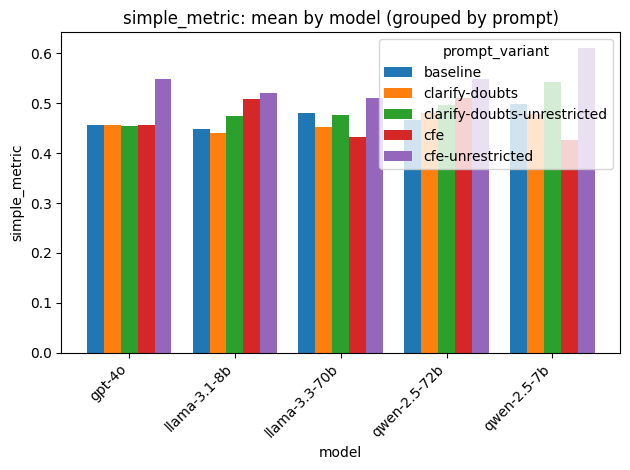

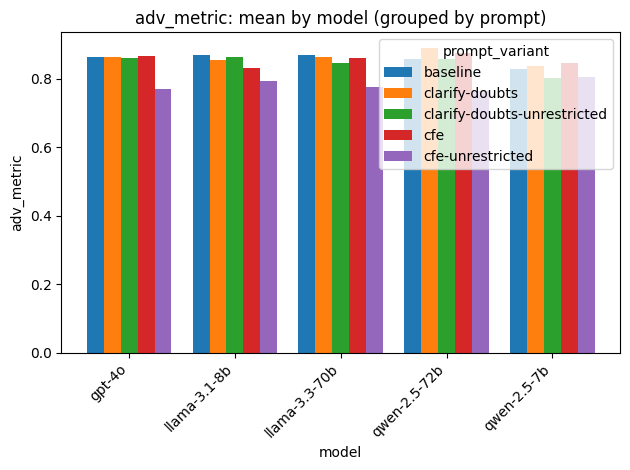

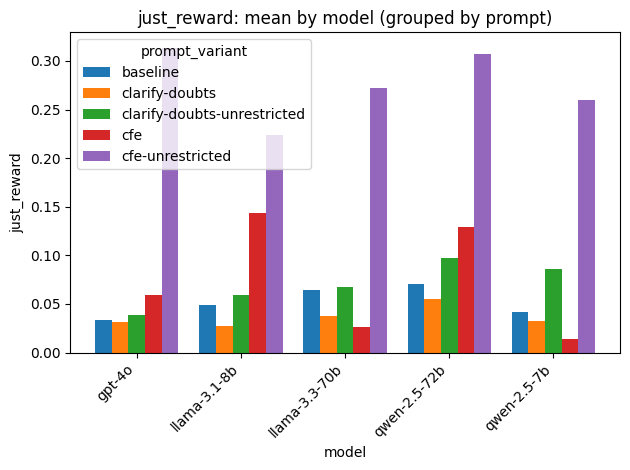

In [6]:
# ------------------------
# Grouped bars per metric: x = models, 3 bars = prompts
#     - One chart per metric
# ------------------------
if "model" in merged_df_metrics.columns and "prompt_variant" in merged_df_metrics.columns and metric_cols:
    models = sorted(merged_df_metrics["model"].dropna().unique().tolist())
    prompts = sorted(merged_df_metrics["prompt_variant"].dropna().unique().tolist())

    for m in metric_cols:
        means = (
            merged_df_metrics
            .groupby(["model", "prompt_variant"])[m]
            .mean()
            .unstack("prompt_variant")
            .reindex(index=models, columns=prompts)
        )
        # prompt_variants must be ordered as baseline, clarify-doubts, cfe
        prompts = sorted(prompts, key=lambda x: ["baseline", "clarify-doubts", "clarify-doubts-unrestricted", "cfe", "cfe-unrestricted"].index(x) if x in ["baseline", "clarify-doubts", "clarify-doubts-unrestricted" ,"cfe", "cfe-unrestricted"] else len(prompts))

        x = np.arange(len(models), dtype=float)
        n_bars = len(prompts)
        if n_bars == 0:
            continue

        # width so that groups don't overlap
        width = 0.8 / n_bars
        offsets = (np.arange(n_bars) - (n_bars - 1) / 2.0) * width

        plt.figure()
        for j, pr in enumerate(prompts):
            y = pd.to_numeric(means[pr], errors="coerce").fillna(0).values
            plt.bar(x + offsets[j], y, width=width, label=str(pr))
        plt.title(f"{m}: mean by model (grouped by prompt)")
        plt.xlabel("model")
        plt.ylabel(m)
        plt.xticks(ticks=x, labels=models, rotation=45, ha="right")
        plt.legend(title="prompt_variant")
        plt.tight_layout()
        plt.show()

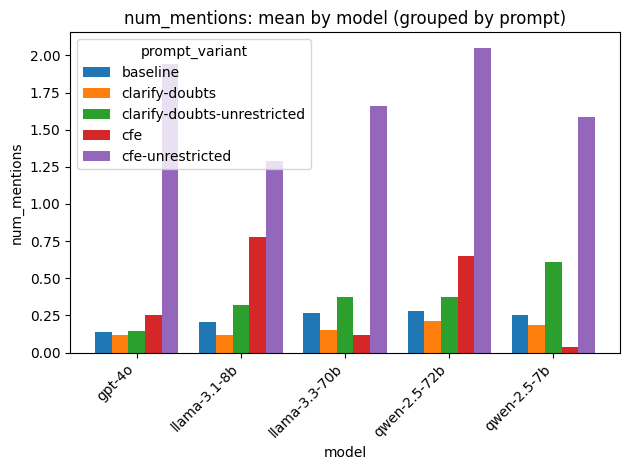

Mean num_mentions: 0.56, Std: 1.08, Max: 9.00


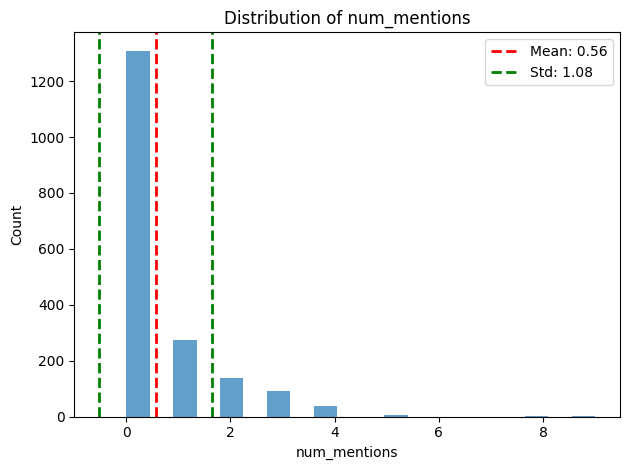

In [7]:
# plot num_mentions by model and prompt_variant
if "model" in merged_df_metrics.columns and "prompt_variant" in merged_df_metrics.columns:
    models = sorted(merged_df_metrics["model"].dropna().unique().tolist())
    prompts = sorted(merged_df_metrics["prompt_variant"].dropna().unique().tolist())

    means = (
        merged_df_metrics
        .groupby(["model", "prompt_variant"])["num_mentions"]
        .mean()
        .unstack("prompt_variant")
        .reindex(index=models, columns=prompts)
    )
    prompts = sorted(prompts, key=lambda x: ["baseline", "clarify-doubts", "clarify-doubts-unrestricted", "cfe", "cfe-unrestricted"].index(x) if x in ["baseline", "clarify-doubts", "clarify-doubts-unrestricted" ,"cfe", "cfe-unrestricted"] else len(prompts))

    x = np.arange(len(models), dtype=float)
    n_bars = len(prompts)
    if n_bars == 0:
        print("No prompts to plot num_mentions.")

    width = 0.8 / n_bars
    offsets = (np.arange(n_bars) - (n_bars - 1)
    / 2.0) * width
    plt.figure()
    for j, pr in enumerate(prompts):
        y = pd.to_numeric(means[pr], errors="coerce").fillna(0).values
        plt.bar(x + offsets[j], y, width=width, label=str(pr))
    plt.title("num_mentions: mean by model (grouped by prompt)")
    plt.xlabel("model")
    plt.ylabel("num_mentions")
    plt.xticks(ticks=x, labels=models, rotation=45, ha="right")
    plt.legend(title="prompt_variant")
    plt.tight_layout()

    plt.show()

# also just plot num_mention values distribution with mean and std IN GENERAL
mean_num_mentions = merged_df_metrics["num_mentions"].mean()
std_num_mentions = merged_df_metrics["num_mentions"].std()
max_num_mentions = merged_df_metrics["num_mentions"].max()
print(f"Mean num_mentions: {mean_num_mentions:.2f}, Std: {std_num_mentions:.2f}, Max: {max_num_mentions:.2f}")
plt.figure()
plt.hist(merged_df_metrics["num_mentions"], bins=20, alpha=0.7)
plt.axvline(mean_num_mentions, color='r', linestyle='dashed', linewidth=
2, label=f'Mean: {mean_num_mentions:.2f}')
plt.axvline(mean_num_mentions + std_num_mentions, color='g', linestyle='dashed', linewidth=2, label=f'Std: {std_num_mentions:.2f}')
plt.axvline(mean_num_mentions - std_num_mentions, color='g', linestyle='dashed', linewidth=2)
plt.title("Distribution of num_mentions")
plt.xlabel("num_mentions")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()



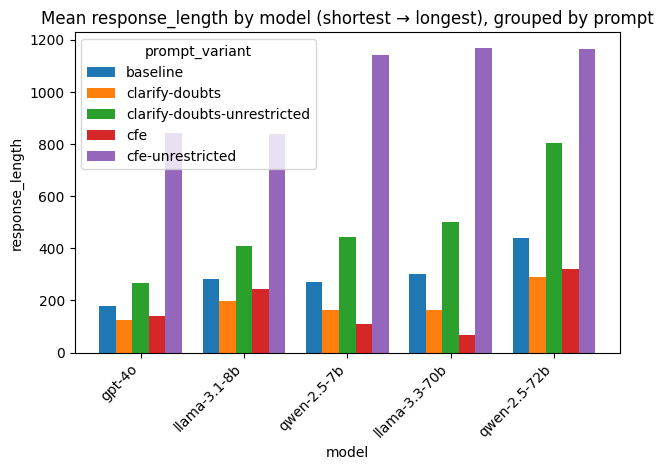

In [8]:
# Compute means per (model x prompt)
prompt_order = ["baseline", "clarify-doubts", "clarify-doubts-unrestricted", "cfe","cfe-unrestricted"]  # desired bar order
available_prompts = [p for p in prompt_order if p in merged_df["prompt_variant"].unique().tolist()]

pivot = (
    merged_df.groupby(["model", "prompt_variant"])["response_length"]
      .mean()
      .unstack("prompt_variant")
      .reindex(columns=available_prompts)
)

# Sort models from shortest to longest by overall mean response length
model_order = pivot.mean(axis=1, skipna=True).sort_values(ascending=True).index.tolist()
pivot = pivot.reindex(index=model_order)

# Plot grouped bars
x = np.arange(len(model_order), dtype=float)
n_bars = len(available_prompts)
width = 0.8 / max(1, n_bars)
offsets = (np.arange(n_bars) - (n_bars - 1) / 2.0) * width

plt.figure()
for j, pr in enumerate(available_prompts):
    y = pivot[pr].astype(float).fillna(0.0).values
    plt.bar(x + offsets[j], y, width=width, label=str(pr))

plt.title("Mean response_length by model (shortest → longest), grouped by prompt")
plt.xlabel("model")
plt.ylabel("response_length")
plt.xticks(ticks=x, labels=model_order, rotation=45, ha="right")
plt.legend(title="prompt_variant")
plt.tight_layout()
plt.show()

In [ ]:
def mentioned_raw_sum(row: pd.Series) -> float:
    """
    Sum of RAW candidate scores for the candidates that were mentioned in the LLM response.
    """
    cand_scores = parse_candidate_scores(row.get("candidate_answers", ""))
    if not cand_scores:
        return 0.0
    canon_scores = { _canon(k): float(v) for k, v in cand_scores.items() }
    mentioned = parse_mentioned(row.get("mentioned_cands", []))
    mentioned_set = { _canon(m) for m in (mentioned or []) }
    return float(sum(canon_scores[k] for k in canon_scores.keys() if k in mentioned_set))
PROMPT_ORDER = [
    "baseline",
    "clarify-doubts",
    "clarify-doubts-unrestricted",
    "cfe",
    "cfe-unrestricted",
    
]

df = pd.read_csv("../data/results/100q_results_all.csv")


In [10]:
merged_df["num_mentions"] = pd.to_numeric(merged_df["num_mentions"], errors="coerce").fillna(0).astype(int)

# Compute per-row mentioned raw score sum
merged_df["mentioned_raw_sum"] = merged_df.apply(mentioned_raw_sum, axis=1)

# Compute per-row average mentioned score; NaN when no mentions to avoid biasing means to 0
merged_df["mentioned_avg_score"] = np.where(
    merged_df["num_mentions"] > 0,
    merged_df["mentioned_raw_sum"] / merged_df["num_mentions"].replace(0, np.nan),
    np.nan
)

# ----------------------------
# Aggregate for plotting
# ----------------------------
# Ensure model and prompt_variant are treated as categorical with desired order for prompts
merged_df["prompt_variant"] = pd.Categorical(merged_df["prompt_variant"], categories=PROMPT_ORDER, ordered=True)

# 1) Mean of per-row average mentioned score (ignore rows with no mentions)
mean_avg = (
    merged_df.dropna(subset=["mentioned_avg_score"])
      .groupby(["model", "prompt_variant"], as_index=False)["mentioned_avg_score"]
      .mean()
)

# Overall average (across all model-prompt rows that had at least one mention)
overall_avg_of_avg = mean_avg["mentioned_avg_score"].mean() if not mean_avg.empty else float("nan")

# 2) Total SUM of mentioned raw scores
sum_raw = (
    merged_df.groupby(["model", "prompt_variant"], as_index=False)["mentioned_raw_sum"]
      .sum()
)

overall_sum_raw = sum_raw["mentioned_raw_sum"].sum() if not sum_raw.empty else 0.0

# Sort models by average_mentioned_score across all prompts

model_order = mean_avg.groupby("model")["mentioned_avg_score"].mean().sort_values(ascending=True).index.tolist()

# Prepare plotting data aligned to model_order and PROMPT_ORDER
def pivot_for_plot(merged_df_in, value_col):
    pivot = merged_df_in.pivot(index="model", columns="prompt_variant", values=value_col)
    # Reindex rows and columns to enforce desired orders
    pivot = pivot.reindex(index=model_order, columns=PROMPT_ORDER)
    return pivot

avg_plot_data = pivot_for_plot(mean_avg, "mentioned_avg_score")
sum_plot_data = pivot_for_plot(sum_raw, "mentioned_raw_sum")

# ----------------------------
# Plot 1: Mean of per-row avg mentioned score
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(avg_plot_data.index))  # models
n_bars = len(PROMPT_ORDER)
bar_width = 0.8 / max(n_bars, 1)

for i, pv in enumerate(PROMPT_ORDER):
    heights = avg_plot_data[pv].values if pv in avg_plot_data.columns else np.zeros_like(x, dtype=float)
    ax.bar(x + i * bar_width, heights, width=bar_width, label=pv)

ax.set_xticks(x + (n_bars - 1) * bar_width / 2)
ax.set_xticklabels(avg_plot_data.index, rotation=0)
ax.set_ylabel("Mean of per-row average mentioned score")
ax.set_title(f"Average Mentioned Score by Model & Prompt  |  Overall mean (mentions-only) = {overall_avg_of_avg:.2f}")
ax.legend(title="prompt_variant", ncol=min(5, n_bars), fontsize=9)

plt.tight_layout()
#plt.savefig("/mnt/data/mentioned_avg_by_model_prompt.png", dpi=200)
plt.show()

""" # ----------------------------
# Plot 2: Total SUM of mentioned raw scores
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(sum_plot_data.index))  # models
n_bars = len(PROMPT_ORDER)
bar_width = 0.8 / max(n_bars, 1)

for i, pv in enumerate(PROMPT_ORDER):
    heights = sum_plot_data[pv].values if pv in sum_plot_data.columns else np.zeros_like(x, dtype=float)
    ax.bar(x + i * bar_width, heights, width=bar_width, label=pv)

ax.set_xticks(x + (n_bars - 1) * bar_width / 2)
ax.set_xticklabels(sum_plot_data.index, rotation=0)
ax.set_ylabel("Total mentioned raw score sum")
ax.set_title(f"Total Mentioned Raw Score by Model & Prompt  |  Overall total = {overall_sum_raw:.1f}")
ax.legend(title="prompt_variant", ncol=min(5, n_bars), fontsize=9)

plt.tight_layout()
#plt.savefig("/mnt/data/mentioned_sum_by_model_prompt.png", dpi=200)
plt.show() """


NameError: name 'mentioned_raw_sum' is not defined